<a href="https://colab.research.google.com/github/Amal1703/COVID-19-Image-Recognition-using-CNN/blob/main/COVID_19_Image_Recognition_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project applies advanced Big Data analysis to the global spread of COVID-19 and explores chest X-ray image recognition for diagnostic forecasting.

The topic of this project is part of 'Advanced Classification using Machine Learning in Healthcare,' offered by IBM on Cognitive Class

In [ ]:
!pip install mahotas
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 11.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mahotas as mh
import kagglehub
import shutil
import os
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

**download data**

In [ ]:
# 1. Download to KaggleHub default cache
src_path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

# 2. Choose your target directory
dst_path = "/content/"

# 3. Copy all files from cache to your directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

100%|██████████| 158M/158M [00:04<00:00, 36.0MB/s]

Extracting files...


'/content/'

Data visualisation

Shape: (1582, 1333, 3)


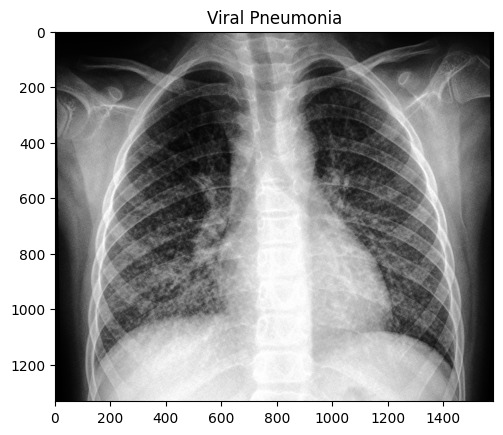

In [ ]:
# Open the image
img = Image.open("/content/Covid19-dataset/train/Viral Pneumonia/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale (gray img), "RGB" = 3 channels (color img)
print("Shape:", (width, height, channels))
plt.title("Viral Pneumonia")
plt.imshow(img)

Shape: (1944, 1708, 3)


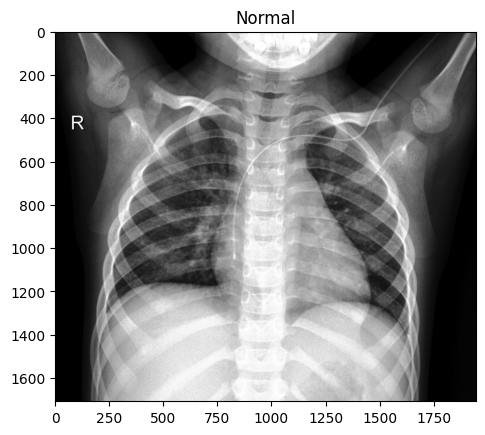

In [ ]:
# Open the image
img = Image.open("/content/Covid19-dataset/train/Normal/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale (gray img), "RGB" = 3 channels (color img)
print("Shape:", (width, height, channels))
plt.title("Normal")
plt.imshow(img)

Shape: (4248, 3480, 3)


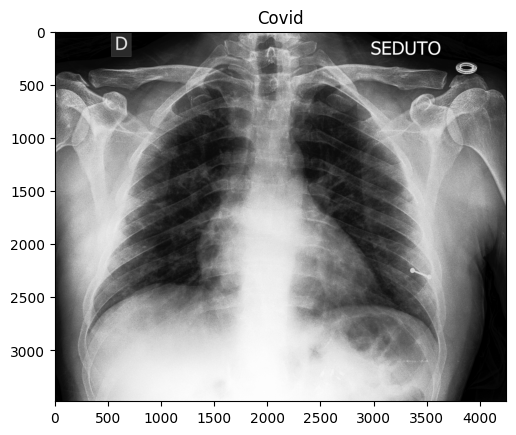

In [ ]:
# Open the image
img = Image.open("/content/Covid19-dataset/train/Covid/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale (gray img), "RGB" = 3 channels (color img)
print("Shape:", (width, height, channels))
plt.title("Covid")
plt.imshow(img)

Images must be of the same size (height, width, and number of channels) for classification → transformation

Transformation (to gray image)

In [ ]:
# Reshape the data
def Reshape_data(output_folder,target_size):
 k=[]
 for folder in os.listdir(output_folder):
  for i in range(len(os.listdir(output_folder))):
    # Open the Normal, Covid or Viral Pneumonia folder
    path=os.path.join(output_folder, os.listdir(output_folder)[i])
    for filename in os.listdir(path):
       if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Image path
        img_path = os.path.join(path, filename)

        # Load the image
        img = mh.imread(img_path)

        # Reshape image to target_size
        if img.ndim == 3: # For a color image
            img_resized = mh.resize_to(img, [target_size, target_size, img.shape[2]])
        else: # img.ndim=2, for a gray image
            img_resized = mh.resize_to(img, [target_size, target_size])

        # Convert a color image to a grayscale image
        if img.ndim == 3:
             img_resized = mh.colors.rgb2grey(img_resized[:,:,:3], dtype = np.uint8)

        data=[]
        data.append(img_resized)
        # For sample i, combine the image matrix with its corresponding label (Normal, Covid or Viral Pneumonia)
        data.append(os.listdir(output_folder)[i])

        # Concatenate all data (image matrix with its corresponding label)
        k.append(data)

 return k


In [ ]:
target_size = 224
train_data = Reshape_data("/content/Covid19-dataset/train",target_size)
test_data = Reshape_data("/content/Covid19-dataset/test",target_size)

Split data : 70% train data, 10% validation data, 20% test data

In [ ]:
# Concatenate the data from the two folders
data_concate = train_data + test_data

In [ ]:
labels = [label for _, label in data_concate]
num_classes = len(set(labels))

# Print the 3 labels : 'Covid', 'Viral Pneumonia', 'Normal'
print(list(set(labels)))

X_train=[]
y_train=[]

X_test=[]
y_test=[]

X_val=[]
y_val=[]

for i in range (num_classes):

 matrices = [m for m, l in data_concate if l == list(set(labels))[i]]
 y_encoded = [list(set(labels))[i]] * len(matrices)

# 70% train , 30% temp for each label
 X_train_1, X_temp, y_train_1, y_temp = train_test_split(
    matrices, y_encoded, test_size=0.3, random_state=50, stratify=y_encoded)

# from temp data: 10% val , 20% test
 X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
    X_temp, y_temp, test_size=0.66, random_state=50, stratify=y_temp)

# Concatenate all the data from the 3 labels
 X_train.extend(X_train_1)
 y_train.extend(y_train_1)

 X_test.extend(X_test_1)
 y_test.extend(y_test_1)

 X_val.extend(X_val_1)
 y_val.extend(y_val_1)

Normalize the data

In [ ]:
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

Encode the outputs: for training, the labels must be numeric (e.g., Covid = 0, Normal = 1, Viral Pneumonia = 2) instead of using the label names

In [ ]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded   = encoder.transform(y_val)
y_test_encoded  = encoder.transform(y_test)

print(encoder.classes_) #  Covid = 0, Normal = 1, Viral Pneumonia = 2

['Covid' 'Normal' 'Viral Pneumonia']


CNN

In [ ]:
def build_cnn(input_shape, number_classes):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
       # layers.Dropout(0.5),
        layers.Dense(number_classes, activation='softmax')
    ])

    return model

In [ ]:
input_shape = (target_size, target_size, 1)
number_classes = len(encoder.classes_)

model = build_cnn(input_shape, number_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,566,371 (21.23 MB)

 Trainable params: 5,566,371 (21.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Stop training if validation loss does not improve after 15 epochs
early_stop = EarlyStopping(
    monitor='val_loss',    # monitor validation loss
    patience=15,            # wait for 15 epochs
    restore_best_weights=True  # restore model weights from best epoch
)

checkpoint = ModelCheckpoint(
    'model.h5',  # Model file name
    monitor='val_loss',  # monitor validation loss
    save_best_only=True # save only the best model
)

In [ ]:
history = model.fit(
    X_train.reshape(-1, target_size, target_size, 1), # (Total number of data, target_size, target_size, 1)
    y_train_encoded, #  (Total number of data)
    epochs=100,
    batch_size=15,
    validation_data=(X_val.reshape(-1, target_size, target_size, 1), y_val_encoded),
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2675 - loss: 1.1086

45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2688 - loss: 1.1085 - val_accuracy: 0.4375 - val_loss: 1.0885
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4347 - loss: 1.0898

45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4346 - loss: 1.0897 - val_accuracy: 0.4375 - val_loss: 1.0736
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4417 - loss: 1.0696

45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4415 - loss: 1.0696 - val_accuracy: 0.4375 - val_loss: 1.0611
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4008 - loss: 1.0738

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4015 - loss: 1.0735 - val_accuracy: 0.4375 - val_loss: 1.0499
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.4270 - loss: 1.0543

45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 994ms/step - accuracy: 0.4271 - loss: 1.0541 - val_accuracy: 0.4375 - val_loss: 1.0376
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.4426 - loss: 1.0342

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4424 - loss: 1.0342 - val_accuracy: 0.4375 - val_loss: 1.0255
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.4600 - loss: 1.0142

45/45 ━━━━━━━━━━━━━━━━━━━━ 78s 924ms/step - accuracy: 0.4594 - loss: 1.0144 - val_accuracy: 0.4375 - val_loss: 1.0130
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.4461 - loss: 1.0080

45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4459 - loss: 1.0081 - val_accuracy: 0.4375 - val_loss: 0.9980
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.4649 - loss: 0.9888

45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 897ms/step - accuracy: 0.4644 - loss: 0.9889 - val_accuracy: 0.4479 - val_loss: 0.9816
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4808 - loss: 0.9730

45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4805 - loss: 0.9731 - val_accuracy: 0.5104 - val_loss: 0.9634
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5179 - loss: 0.9541

45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5175 - loss: 0.9542 - val_accuracy: 0.5938 - val_loss: 0.9459
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5771 - loss: 0.9414

45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5771 - loss: 0.9414 - val_accuracy: 0.6562 - val_loss: 0.9277
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.6004 - loss: 0.9250

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.6003 - loss: 0.9249 - val_accuracy: 0.6875 - val_loss: 0.9090
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.5973 - loss: 0.9189

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 967ms/step - accuracy: 0.5979 - loss: 0.9186 - val_accuracy: 0.6771 - val_loss: 0.8891
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.6464 - loss: 0.8931

45/45 ━━━━━━━━━━━━━━━━━━━━ 78s 889ms/step - accuracy: 0.6469 - loss: 0.8930 - val_accuracy: 0.7812 - val_loss: 0.8669
Epoch 16/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.7143 - loss: 0.8615

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.7142 - loss: 0.8615 - val_accuracy: 0.7708 - val_loss: 0.8450
Epoch 17/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.7441 - loss: 0.8313

45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 878ms/step - accuracy: 0.7441 - loss: 0.8315 - val_accuracy: 0.8125 - val_loss: 0.8234
Epoch 18/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.7416 - loss: 0.8139

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 894ms/step - accuracy: 0.7420 - loss: 0.8140 - val_accuracy: 0.8125 - val_loss: 0.8016
Epoch 19/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.7926 - loss: 0.7927

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 912ms/step - accuracy: 0.7928 - loss: 0.7926 - val_accuracy: 0.8021 - val_loss: 0.7806
Epoch 20/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7927 - loss: 0.7711

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 898ms/step - accuracy: 0.7925 - loss: 0.7711 - val_accuracy: 0.8333 - val_loss: 0.7601
Epoch 21/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8255 - loss: 0.7510

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 894ms/step - accuracy: 0.8253 - loss: 0.7508 - val_accuracy: 0.8438 - val_loss: 0.7404
Epoch 22/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.7954 - loss: 0.7421

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 936ms/step - accuracy: 0.7963 - loss: 0.7418 - val_accuracy: 0.8854 - val_loss: 0.7209
Epoch 23/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8095 - loss: 0.7230

45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8103 - loss: 0.7228 - val_accuracy: 0.8854 - val_loss: 0.7011
Epoch 24/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.8733 - loss: 0.6842

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 900ms/step - accuracy: 0.8731 - loss: 0.6842 - val_accuracy: 0.8750 - val_loss: 0.6813
Epoch 25/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8368 - loss: 0.6793

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 905ms/step - accuracy: 0.8370 - loss: 0.6791 - val_accuracy: 0.8854 - val_loss: 0.6635
Epoch 26/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.8629 - loss: 0.6314

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.8627 - loss: 0.6317 - val_accuracy: 0.8958 - val_loss: 0.6457
Epoch 27/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8759 - loss: 0.6287

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 883ms/step - accuracy: 0.8758 - loss: 0.6287 - val_accuracy: 0.8958 - val_loss: 0.6280
Epoch 28/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8574 - loss: 0.6245

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 905ms/step - accuracy: 0.8576 - loss: 0.6242 - val_accuracy: 0.8958 - val_loss: 0.6112
Epoch 29/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8818 - loss: 0.6031

45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 870ms/step - accuracy: 0.8820 - loss: 0.6029 - val_accuracy: 0.9062 - val_loss: 0.5949
Epoch 30/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.8675 - loss: 0.5878

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 873ms/step - accuracy: 0.8678 - loss: 0.5876 - val_accuracy: 0.8958 - val_loss: 0.5804
Epoch 31/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.8775 - loss: 0.5770

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 871ms/step - accuracy: 0.8777 - loss: 0.5767 - val_accuracy: 0.8958 - val_loss: 0.5655
Epoch 32/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9017 - loss: 0.5382

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 915ms/step - accuracy: 0.9013 - loss: 0.5384 - val_accuracy: 0.8958 - val_loss: 0.5509
Epoch 33/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9099 - loss: 0.5296

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 881ms/step - accuracy: 0.9098 - loss: 0.5297 - val_accuracy: 0.9062 - val_loss: 0.5375
Epoch 34/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9130 - loss: 0.5169

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 938ms/step - accuracy: 0.9128 - loss: 0.5170 - val_accuracy: 0.9167 - val_loss: 0.5257
Epoch 35/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8926 - loss: 0.5159

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 879ms/step - accuracy: 0.8928 - loss: 0.5156 - val_accuracy: 0.9062 - val_loss: 0.5122
Epoch 36/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8980 - loss: 0.4962

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 915ms/step - accuracy: 0.8978 - loss: 0.4962 - val_accuracy: 0.9167 - val_loss: 0.5017
Epoch 37/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.9112 - loss: 0.4956

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9112 - loss: 0.4953 - val_accuracy: 0.9167 - val_loss: 0.4892
Epoch 38/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.8940 - loss: 0.4871

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 889ms/step - accuracy: 0.8942 - loss: 0.4867 - val_accuracy: 0.9167 - val_loss: 0.4775
Epoch 39/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9047 - loss: 0.4632

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 892ms/step - accuracy: 0.9048 - loss: 0.4630 - val_accuracy: 0.9167 - val_loss: 0.4683
Epoch 40/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9007 - loss: 0.4535

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 898ms/step - accuracy: 0.9009 - loss: 0.4534 - val_accuracy: 0.9167 - val_loss: 0.4583
Epoch 41/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9235 - loss: 0.4326

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 908ms/step - accuracy: 0.9235 - loss: 0.4327 - val_accuracy: 0.9167 - val_loss: 0.4487
Epoch 42/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9155 - loss: 0.4287

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.9155 - loss: 0.4287 - val_accuracy: 0.9167 - val_loss: 0.4393
Epoch 43/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9333 - loss: 0.4007

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.9330 - loss: 0.4010 - val_accuracy: 0.9167 - val_loss: 0.4308
Epoch 44/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9061 - loss: 0.4295

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.9064 - loss: 0.4292 - val_accuracy: 0.9167 - val_loss: 0.4223
Epoch 45/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9081 - loss: 0.4170

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.9082 - loss: 0.4168 - val_accuracy: 0.8958 - val_loss: 0.4159
Epoch 46/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9200 - loss: 0.4034

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 887ms/step - accuracy: 0.9199 - loss: 0.4033 - val_accuracy: 0.8958 - val_loss: 0.4060
Epoch 47/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9168 - loss: 0.3739

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 907ms/step - accuracy: 0.9168 - loss: 0.3741 - val_accuracy: 0.8958 - val_loss: 0.3997
Epoch 48/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9165 - loss: 0.3831

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.9163 - loss: 0.3830 - val_accuracy: 0.9167 - val_loss: 0.3902
Epoch 49/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9090 - loss: 0.3750

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 923ms/step - accuracy: 0.9092 - loss: 0.3749 - val_accuracy: 0.8958 - val_loss: 0.3845
Epoch 50/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9188 - loss: 0.3589

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 901ms/step - accuracy: 0.9186 - loss: 0.3591 - val_accuracy: 0.8958 - val_loss: 0.3806
Epoch 51/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9234 - loss: 0.3590

45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9233 - loss: 0.3589 - val_accuracy: 0.8958 - val_loss: 0.3755
Epoch 52/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9144 - loss: 0.3694

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 909ms/step - accuracy: 0.9144 - loss: 0.3691 - val_accuracy: 0.8958 - val_loss: 0.3666
Epoch 53/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9197 - loss: 0.3522

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 945ms/step - accuracy: 0.9198 - loss: 0.3521 - val_accuracy: 0.8958 - val_loss: 0.3604
Epoch 54/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9291 - loss: 0.3300

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 902ms/step - accuracy: 0.9289 - loss: 0.3302 - val_accuracy: 0.8958 - val_loss: 0.3546
Epoch 55/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9054 - loss: 0.3418

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 901ms/step - accuracy: 0.9057 - loss: 0.3416 - val_accuracy: 0.8958 - val_loss: 0.3482
Epoch 56/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9106 - loss: 0.3312

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 933ms/step - accuracy: 0.9107 - loss: 0.3311 - val_accuracy: 0.8958 - val_loss: 0.3443
Epoch 57/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9224 - loss: 0.3225

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 918ms/step - accuracy: 0.9224 - loss: 0.3225 - val_accuracy: 0.8958 - val_loss: 0.3392
Epoch 58/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.9262 - loss: 0.3092

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 944ms/step - accuracy: 0.9262 - loss: 0.3092 - val_accuracy: 0.8958 - val_loss: 0.3327
Epoch 59/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.9232 - loss: 0.3030

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 913ms/step - accuracy: 0.9232 - loss: 0.3031 - val_accuracy: 0.8958 - val_loss: 0.3290
Epoch 60/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9284 - loss: 0.3041

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 904ms/step - accuracy: 0.9283 - loss: 0.3042 - val_accuracy: 0.9062 - val_loss: 0.3235
Epoch 61/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9027 - loss: 0.3223

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 917ms/step - accuracy: 0.9029 - loss: 0.3220 - val_accuracy: 0.9062 - val_loss: 0.3212
Epoch 62/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9329 - loss: 0.3058

45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9328 - loss: 0.3056 - val_accuracy: 0.8958 - val_loss: 0.3149
Epoch 63/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9196 - loss: 0.2974

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 912ms/step - accuracy: 0.9195 - loss: 0.2974 - val_accuracy: 0.9062 - val_loss: 0.3121
Epoch 64/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9135 - loss: 0.3012

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 915ms/step - accuracy: 0.9136 - loss: 0.3011 - val_accuracy: 0.9062 - val_loss: 0.3071
Epoch 65/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9438 - loss: 0.2768

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 911ms/step - accuracy: 0.9436 - loss: 0.2770 - val_accuracy: 0.8958 - val_loss: 0.3043
Epoch 66/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9128 - loss: 0.3018

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 906ms/step - accuracy: 0.9130 - loss: 0.3014 - val_accuracy: 0.9062 - val_loss: 0.3020
Epoch 67/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9014 - loss: 0.3062

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 962ms/step - accuracy: 0.9018 - loss: 0.3058 - val_accuracy: 0.9062 - val_loss: 0.2980
Epoch 68/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9232 - loss: 0.2770

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 898ms/step - accuracy: 0.9232 - loss: 0.2770 - val_accuracy: 0.9062 - val_loss: 0.2929
Epoch 69/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9422 - loss: 0.2563

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - accuracy: 0.9418 - loss: 0.2567 - val_accuracy: 0.9062 - val_loss: 0.2898
Epoch 70/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9350 - loss: 0.2604

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 906ms/step - accuracy: 0.9348 - loss: 0.2605 - val_accuracy: 0.9062 - val_loss: 0.2869
Epoch 71/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9245 - loss: 0.2648

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 897ms/step - accuracy: 0.9245 - loss: 0.2648 - val_accuracy: 0.9062 - val_loss: 0.2848
Epoch 72/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9174 - loss: 0.2657

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 902ms/step - accuracy: 0.9175 - loss: 0.2657 - val_accuracy: 0.9062 - val_loss: 0.2791
Epoch 73/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9068 - loss: 0.2741

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 913ms/step - accuracy: 0.9072 - loss: 0.2738 - val_accuracy: 0.9062 - val_loss: 0.2774
Epoch 74/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 889ms/step - accuracy: 0.9333 - loss: 0.2470 - val_accuracy: 0.9062 - val_loss: 0.2777
Epoch 75/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9266 - loss: 0.2440

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 888ms/step - accuracy: 0.9267 - loss: 0.2441 - val_accuracy: 0.9062 - val_loss: 0.2717
Epoch 76/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9230 - loss: 0.2507

45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9228 - loss: 0.2506 - val_accuracy: 0.9167 - val_loss: 0.2693
Epoch 77/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9445 - loss: 0.2258

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - accuracy: 0.9441 - loss: 0.2263 - val_accuracy: 0.9062 - val_loss: 0.2680
Epoch 78/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9260 - loss: 0.2590

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 921ms/step - accuracy: 0.9260 - loss: 0.2586 - val_accuracy: 0.9167 - val_loss: 0.2652
Epoch 79/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9341 - loss: 0.2335

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 899ms/step - accuracy: 0.9342 - loss: 0.2336 - val_accuracy: 0.9062 - val_loss: 0.2626
Epoch 80/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9412 - loss: 0.2360

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 903ms/step - accuracy: 0.9409 - loss: 0.2361 - val_accuracy: 0.9167 - val_loss: 0.2593
Epoch 81/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 964ms/step - accuracy: 0.9362 - loss: 0.2403 - val_accuracy: 0.9167 - val_loss: 0.2595
Epoch 82/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9285 - loss: 0.2432

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 909ms/step - accuracy: 0.9285 - loss: 0.2430 - val_accuracy: 0.9167 - val_loss: 0.2561
Epoch 83/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9308 - loss: 0.2101

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 908ms/step - accuracy: 0.9308 - loss: 0.2106 - val_accuracy: 0.9167 - val_loss: 0.2544
Epoch 84/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9388 - loss: 0.2231

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 931ms/step - accuracy: 0.9386 - loss: 0.2232 - val_accuracy: 0.9167 - val_loss: 0.2515
Epoch 85/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9603 - loss: 0.2041

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 922ms/step - accuracy: 0.9598 - loss: 0.2047 - val_accuracy: 0.9167 - val_loss: 0.2500
Epoch 86/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9256 - loss: 0.2333

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 897ms/step - accuracy: 0.9258 - loss: 0.2332 - val_accuracy: 0.9167 - val_loss: 0.2468
Epoch 87/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9283 - loss: 0.2291

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 905ms/step - accuracy: 0.9286 - loss: 0.2290 - val_accuracy: 0.9375 - val_loss: 0.2447
Epoch 88/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 906ms/step - accuracy: 0.9263 - loss: 0.2219 - val_accuracy: 0.9167 - val_loss: 0.2470
Epoch 89/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9195 - loss: 0.2357

45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.9198 - loss: 0.2353 - val_accuracy: 0.9167 - val_loss: 0.2436
Epoch 90/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9484 - loss: 0.2078

45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9482 - loss: 0.2080 - val_accuracy: 0.9167 - val_loss: 0.2392
Epoch 91/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9466 - loss: 0.2009

45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 902ms/step - accuracy: 0.9464 - loss: 0.2012 - val_accuracy: 0.9167 - val_loss: 0.2375
Epoch 92/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9375 - loss: 0.2034

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 933ms/step - accuracy: 0.9375 - loss: 0.2037 - val_accuracy: 0.9375 - val_loss: 0.2362
Epoch 93/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 905ms/step - accuracy: 0.9442 - loss: 0.2090 - val_accuracy: 0.9271 - val_loss: 0.2366
Epoch 94/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9468 - loss: 0.1971

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 907ms/step - accuracy: 0.9466 - loss: 0.1973 - val_accuracy: 0.9271 - val_loss: 0.2316
Epoch 95/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9318 - loss: 0.1959

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 938ms/step - accuracy: 0.9318 - loss: 0.1961 - val_accuracy: 0.9271 - val_loss: 0.2306
Epoch 96/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9394 - loss: 0.2196

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - accuracy: 0.9395 - loss: 0.2193 - val_accuracy: 0.9375 - val_loss: 0.2279
Epoch 97/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9487 - loss: 0.1953

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 916ms/step - accuracy: 0.9486 - loss: 0.1954 - val_accuracy: 0.9271 - val_loss: 0.2262
Epoch 98/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9497 - loss: 0.1815

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 934ms/step - accuracy: 0.9495 - loss: 0.1819 - val_accuracy: 0.9271 - val_loss: 0.2253
Epoch 99/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9415 - loss: 0.1976

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 901ms/step - accuracy: 0.9415 - loss: 0.1977 - val_accuracy: 0.9479 - val_loss: 0.2231
Epoch 100/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9301 - loss: 0.2138

45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9303 - loss: 0.2135 - val_accuracy: 0.9271 - val_loss: 0.2216


Plot the training and validation loss and accuracy over epochs

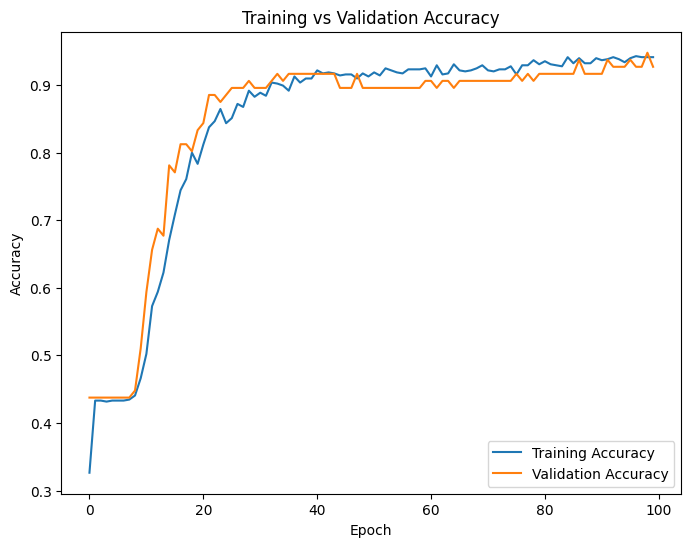

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

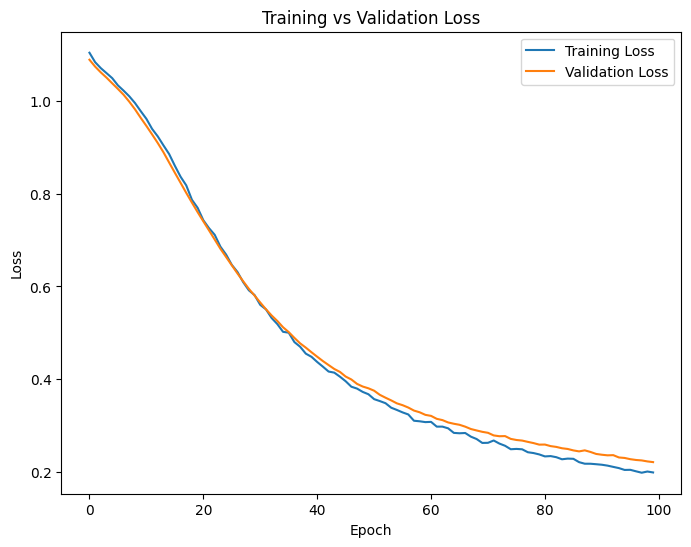

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Make predictions on the test set

In [ ]:
# load model
model = load_model("model.h5")

# evaluate model
loss, acc = model.evaluate(X_test.reshape(-1, target_size, target_size, 1), y_test_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9527 - loss: 0.1549


In [ ]:
# Make predictions on the test set
y_pred_test = model.predict(X_test.reshape(-1, target_size, target_size, 1))

# Convert the predictions to class labels
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 751ms/step


Confusion matrix

['Covid' 'Normal' 'Viral Pneumonia']


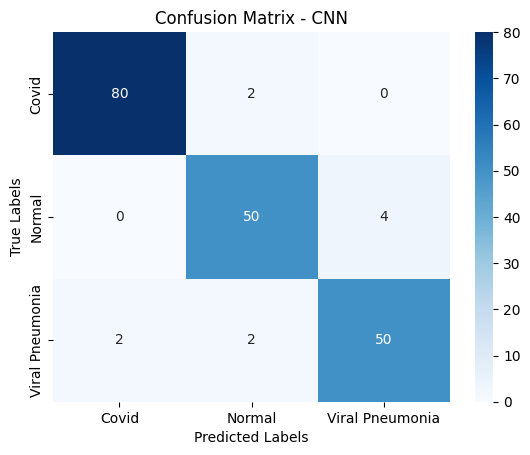

In [ ]:
# confusion matrix : Rows → true labels (y_test_encoded), Columns → predicted labels (y_pred_classes_test)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes_test)

# Plot confusion matrix : row 0 = Covid, row 1 = Normal, row 2 =  Viral Pneumonia
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()